In [ ]:
'''
# Overview:  
This is a forecast of US covid-19 infections base on current national data and the assumption that the virus will
follow a logistic curve.

## For background see: 
*Exponential growth and epidemics*  
3Blue1Brown  
https://youtu.be/Kas0tIxDvrg for the basic math.[1]

*The Mathematics Behind the Coronavirus Spread*  
By Stu Schwartz, www.MasterMathMentor.com  
http://www.mastermathmentor.com/mmm-archive/CoronaVirus.pdf[2]  

The conclusion from both of the above references is that historially viruses follow a logistic curve.  
Page 8 of Schwartz[2]  implies that the general formula for logistic curves for viral growth is:  
cases = capacity / (1+p1*(e^(p2*day))

So the idea here  is to solve for capacity, p1 and p2 using curve fitting.

capacity is the theortical maximum number of infections.

## Data Sources
Covid Tracking Project: https://covidtracking.com/  
American Hospital Association: https://www.aha.org/statistics/fast-facts-us-hospitals  

## Credit
This code borrows heavily from:  
https://github.com/KentShikama/covid19-curve-fitting#hackathon-quality-curve-fitting-for-us-covid19-cases 

## License
MIT License  

## Author
David Brumbaugh

'''

In [511]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit

In [512]:
'''
Logistic Curve
e = 2.71828 (Natrual log)
'''
def model(x,capacity,p1,p2):
    e =  2.71828  
    #x starts with 1
    numerator = 1.00+(p1*(e**(p2*(x-1))))    
    return capacity/numerator

In [517]:
'''
Hospital Beds Source: https://www.aha.org/statistics/fast-facts-us-hospitals
'''

def plot_national_graph(days, days_so_far, national_cases, deaths, recovered, now_hosp, now_vent, results=[],last_date=''):
    plt.rcParams["figure.figsize"] = (18,10)
    plt.title("Covid-19: US National Confirmed Cases vs. Forecast Cases")
    plt.scatter(days_so_far, national_cases, label=f"Confirmed cases") 
    plt.scatter(days_so_far, deaths,marker='v',c='k', label=f"Attributed Deaths") 
    plt.scatter(days_so_far, recovered,marker='^',c='g', label=f"Known Recoveries") 
    plt.scatter(days_so_far, now_hosp,marker='.',c='#ffa500', label=f"Currently Hospitalized") 
    plt.scatter(days_so_far, now_vent,marker='*',c='#ff8500', label=f"Currently on Ventilator")
    plt.plot(days, results, 'r--', label=f"Forecast cases")
    hospital_beds_line_data = np.array([924107 for i in range(len(days))])
    plt.plot(days, hospital_beds_line_data, 'c--', label=f"All Staffed Hospital Beds")
    plt.text(2,924000,'All Hospital Beds')
    icu_beds_line_data = np.array([55633 for i in range(len(days))])
    plt.plot(days, icu_beds_line_data, 'b--', label=f"General ICU Beds")
    plt.text(2,55700,'ICU Beds')
    plt.xlabel(f'# days since March 4th, 2020')
    plt.legend(loc=5)
    plt.text(2,(national_cases[-1] - 5),last_date)
    plt.text(days[-1]-22,250000,'Data Source: Covid Tracking Project: https://covidtracking.com/')
    plt.text(days[-1]-25,220000,'Hospital Beds Source: https://www.aha.org/statistics/fast-facts-us-hospitals')
    plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    # plt.savefig(f'all.png', bbox_inches='tight')
    plt.show()
    plt.close()

In [518]:
def plot_growth_factor(days,growth_factor, last_date='test'):
    plt.rcParams["figure.figsize"] = (18,10)
    plt.title("Covid-19: National Growth Factor")     
    plt.plot(days, growth_factor, 'g-', label=f"Growth Factor")
    plt.xlabel(f'# days since March 4th, 2020')
    plt.legend(loc=5)
    plt.text(1,3.2,last_date)
    plt.text(days[-1]-20,0.2,'Data Source: Covid Tracking Project: https://covidtracking.com/')
    plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    # plt.savefig(f'all.png', bbox_inches='tight')
    horiz_line_data = np.array([1 for i in range(len(days))])
    plt.plot(days, horiz_line_data, 'k--') 
    plt.show()
    plt.close()

In [519]:
'''
(C8-C7)/(C7-C6)
(y[n]-y[n-1]) / (y[n-1] - y[n-2]) 
'''
def compute_growth_factor(y):
    growth_factor = [0,0] #First two days have to be blank
    lenY = len(y)
    for n in range(lenY):
        if n > 1:
            gf = (y[n] - y[n-1]) / (y[n-1] - y[n-2])
            growth_factor.append(gf)
            
    return growth_factor
    

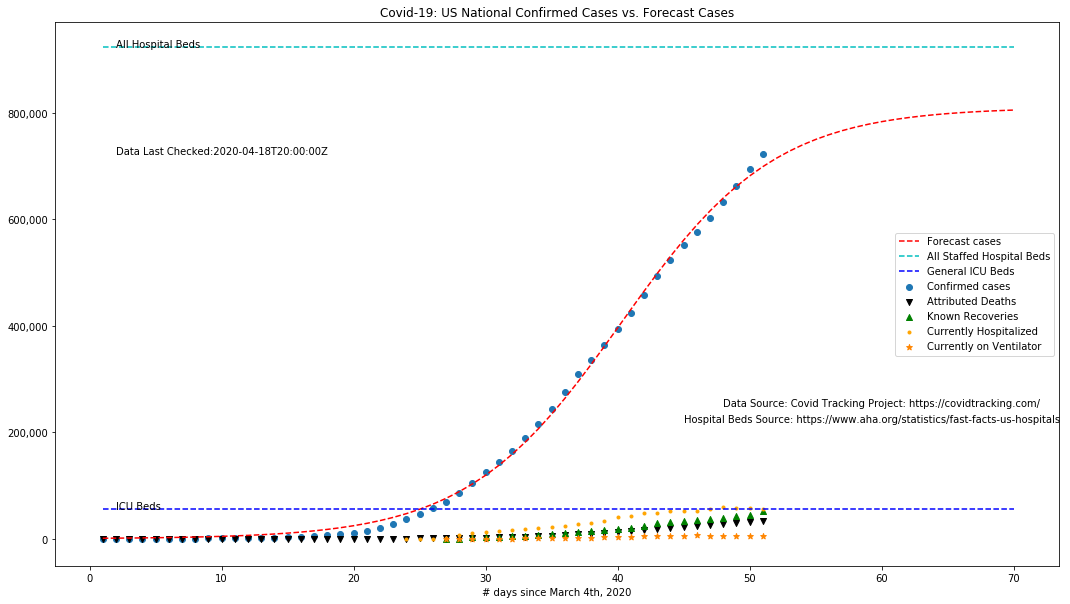

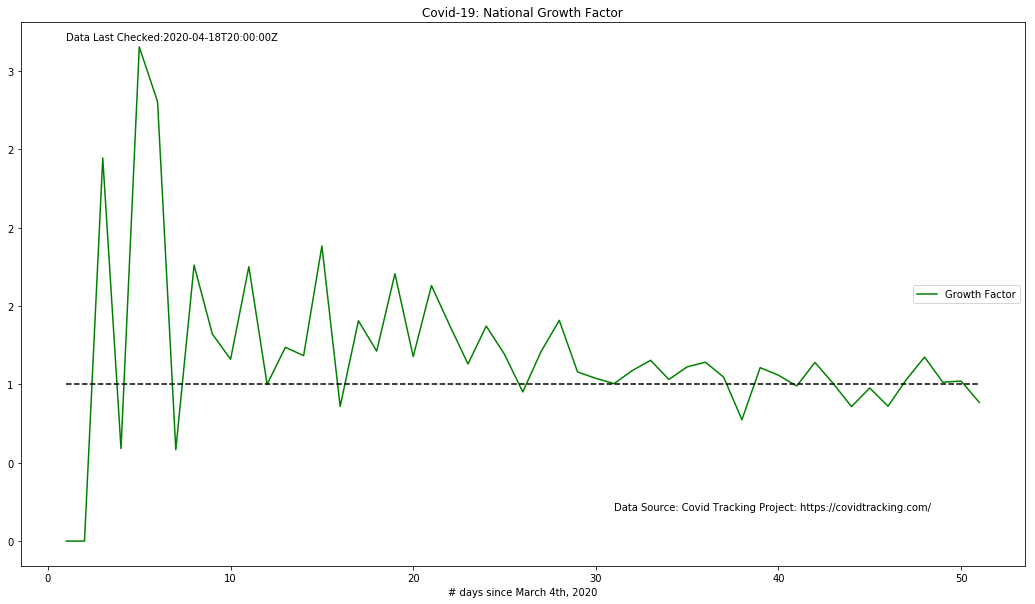

In [520]:
df = pd.read_json("https://covidtracking.com/api/us/daily").iloc[::-1]



national_initial_date = pd.to_datetime(df["date"].min(), format="%Y%m%d")
national_initial_date_as_int = national_initial_date.timestamp() / 86400
national_last_date = df["dateChecked"][0]


dates = pd.to_datetime(df["date"], format="%Y%m%d")
dates_as_int = dates.astype(int) / 10 ** 9 / 86400
dates_as_int_array = dates_as_int.to_numpy()
dates_as_int_array_normalized = dates_as_int_array - dates_as_int_array[0]
national_cases = df["positive"].to_numpy()
national_deaths = df["death"].to_numpy()
national_recovery = df["recovered"].to_numpy()
nat_now_hospitalized = df["hospitalizedCurrently"].to_numpy()
nat_now_vent = df["onVentilatorCurrently"].to_numpy()
days_so_far = np.arange(1, len(national_cases) + 1)
days = np.arange(1,  len(national_cases)+20)


popt, pcov = curve_fit(model, days_so_far, national_cases,p0=[1000000,1000,-0.25])
offset = 0
results = np.concatenate((np.zeros(int(offset)), model(days, *popt)))
plot_national_graph(days, days_so_far, national_cases,national_deaths,national_recovery,nat_now_hospitalized, nat_now_vent, results,'Data Last Checked:'+national_last_date)
# plot_national_graph(days, days_so_far, pcov)

growth_factor = compute_growth_factor(national_cases)


plot_growth_factor(days_so_far, growth_factor,'Data Last Checked:'+national_last_date)
# print(popt)
    